In [39]:
from torchvision import models
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dataset import CustomImageSet, OCT5kDataset
from sklearn.model_selection import train_test_split
from plots import plot_features, plot_biomarkers
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, silhouette_score

In [2]:
cuda = torch.device("cuda")

In [93]:
resnet50_transforms = transforms.Compose([
    transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    #transforms.RandomRotation(degrees=30),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.299, 0.244, 0.225])
])

In [42]:
test_path = "C:/Users/voicu/OneDrive/Desktop/licenta/OCT2017/test"

test_dataset = CustomImageSet(test_path, transform=resnet50_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [43]:
# loading the model
resnet50_features = models.resnet50()
resnet50_features.fc = nn.Linear(resnet50_features.fc.in_features, 4)
resnet50_features.load_state_dict(torch.load("models/resnet50_fine_tuning2.pth"))
resnet50_features.to(cuda)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [44]:
embeds = {}


def get_activation(name):
    def hook(model, input, output):
        embeds[name] = output

    return hook

In [45]:
avgpool_layer = resnet50_features.avgpool
hook_avgpool = avgpool_layer.register_forward_hook(get_activation('avgpool'))

In [46]:
def extract_conv_features(dataloader, model, layer):
    model.eval()
    features = []
    labels_list = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(cuda)
            labels = labels.to(cuda)

            _ = model(images)

            features.append(embeds[layer].cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features = np.concatenate(features)
    labels = np.concatenate(labels_list)
    return features, labels

In [47]:
avgpool_features, avgpool_labels = extract_conv_features(test_dataloader, resnet50_features, 'avgpool')
hook_avgpool.remove()

In [48]:
avgpool_features = avgpool_features.reshape(avgpool_features.shape[0], -1)

In [49]:
n_clusters = 4

kmeans_avg4 = KMeans(n_clusters=n_clusters, random_state=42).fit(avgpool_features)
avg_labels4 = kmeans_avg4.predict(avgpool_features)

In [50]:
sil_score = silhouette_score(avgpool_features, avg_labels4)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.13748885691165924


In [51]:
def KMeansMetrics(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    print(classification_report(y_test, y_pred))

    acc = accuracy_score(y_pred, y_test)
    print(f'Accuracy: {acc}')

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       145
           1       0.98      0.98      0.98       165
           2       1.00      0.96      0.98       227
           3       0.90      0.99      0.94       143

    accuracy                           0.97       680
   macro avg       0.96      0.97      0.96       680
weighted avg       0.97      0.97      0.97       680

Accuracy: 0.9661764705882353


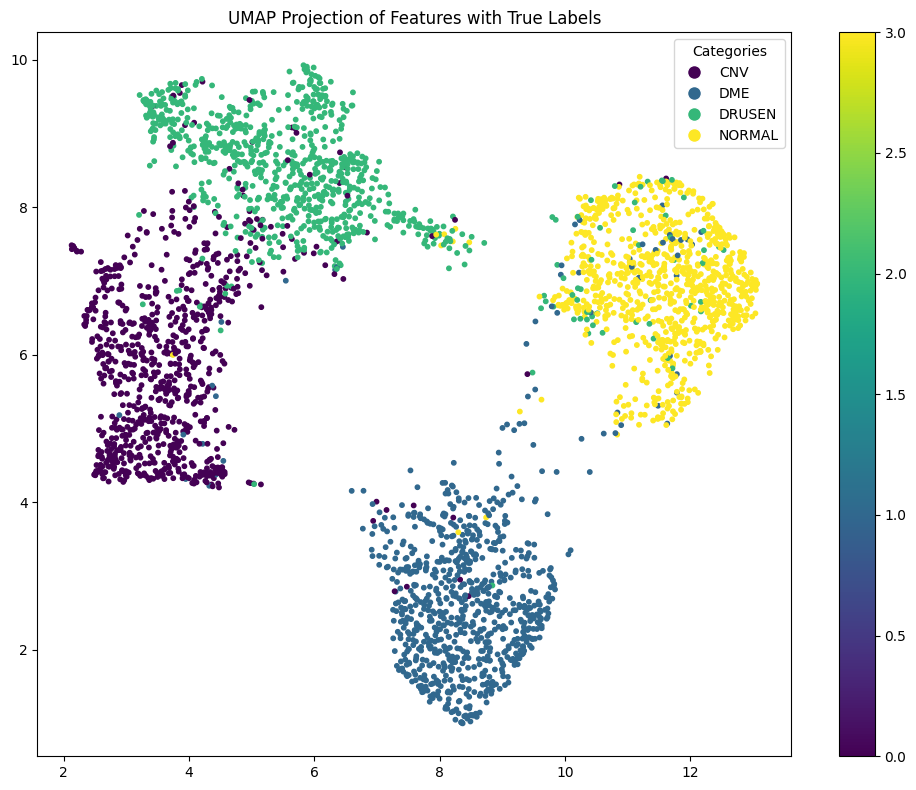

In [53]:
KMeansMetrics(avgpool_features, avg_labels4)
plot_features(avgpool_features, avg_labels4, avgpool_labels,
              category_names={0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'})

In [54]:
n_clusters = 5

kmeans_avg5 = KMeans(n_clusters=n_clusters, random_state=42).fit(avgpool_features)
avg_labels5 = kmeans_avg5.predict(avgpool_features)

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       144
           1       0.99      0.98      0.98       162
           2       0.95      0.73      0.83       105
           3       0.90      0.98      0.94       140
           4       0.86      0.99      0.92       129

    accuracy                           0.94       680
   macro avg       0.94      0.92      0.93       680
weighted avg       0.94      0.94      0.93       680

Accuracy: 0.9352941176470588


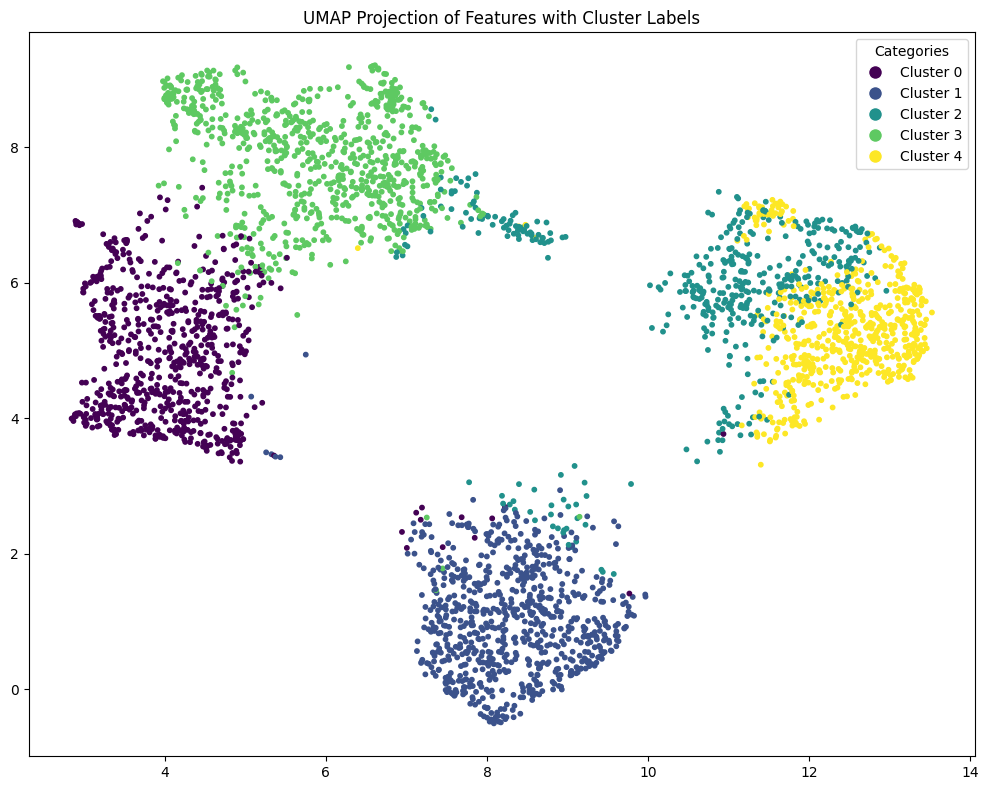

In [56]:
KMeansMetrics(avgpool_features, avg_labels5)
plot_biomarkers(avgpool_features, avg_labels5)

In [57]:
n_clusters = 6

kmeans_avg6 = KMeans(n_clusters=n_clusters, random_state=42).fit(avgpool_features)
avg_labels6 = kmeans_avg6.predict(avgpool_features)

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       106
           1       0.97      0.98      0.97       163
           2       0.92      0.74      0.82        96
           3       0.98      0.98      0.98        43
           4       0.87      0.97      0.92       129
           5       0.98      0.92      0.95       143

    accuracy                           0.93       680
   macro avg       0.93      0.92      0.93       680
weighted avg       0.93      0.93      0.93       680

Accuracy: 0.9279411764705883


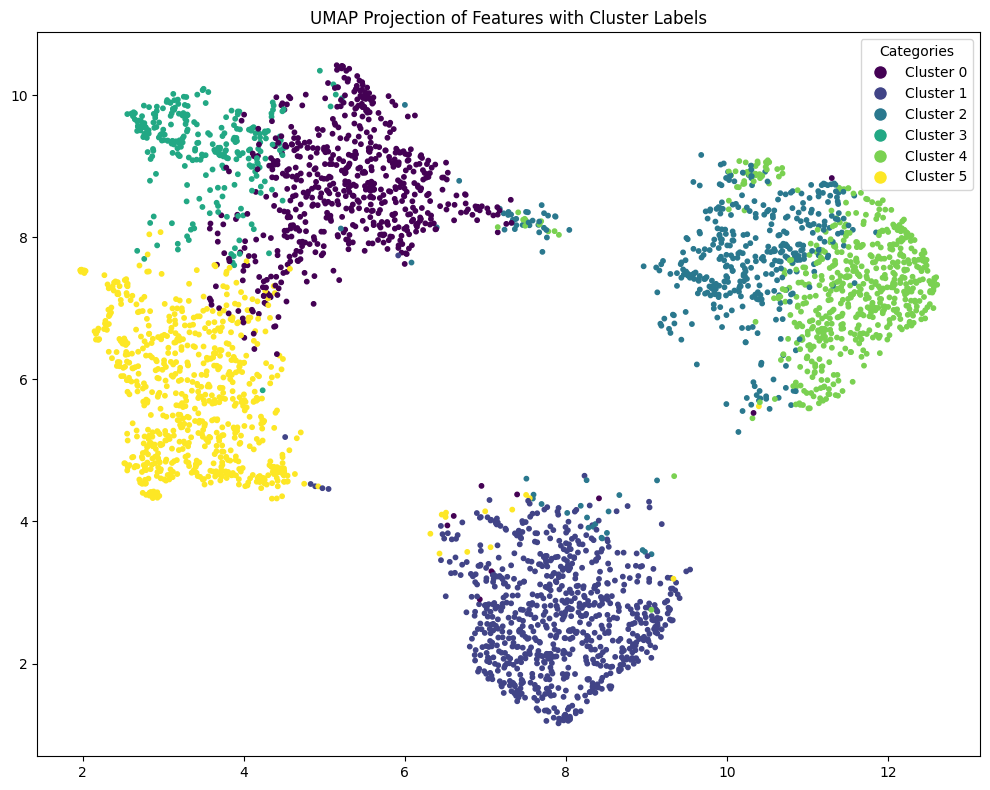

In [58]:
KMeansMetrics(avgpool_features, avg_labels6)
plot_biomarkers(avgpool_features, avg_labels6)

In [74]:
n_clusters = 7

kmeans_avg7 = KMeans(n_clusters=n_clusters, random_state=42).fit(avgpool_features)
avg_labels7 = kmeans_avg7.predict(avgpool_features)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       107
           1       0.92      0.81      0.86        72
           2       0.88      0.79      0.83        92
           3       0.93      0.98      0.95        43
           4       0.87      0.95      0.91       123
           5       0.98      0.93      0.96       138
           6       0.87      0.88      0.87       105

    accuracy                           0.90       680
   macro avg       0.90      0.90      0.90       680
weighted avg       0.90      0.90      0.90       680

Accuracy: 0.9014705882352941


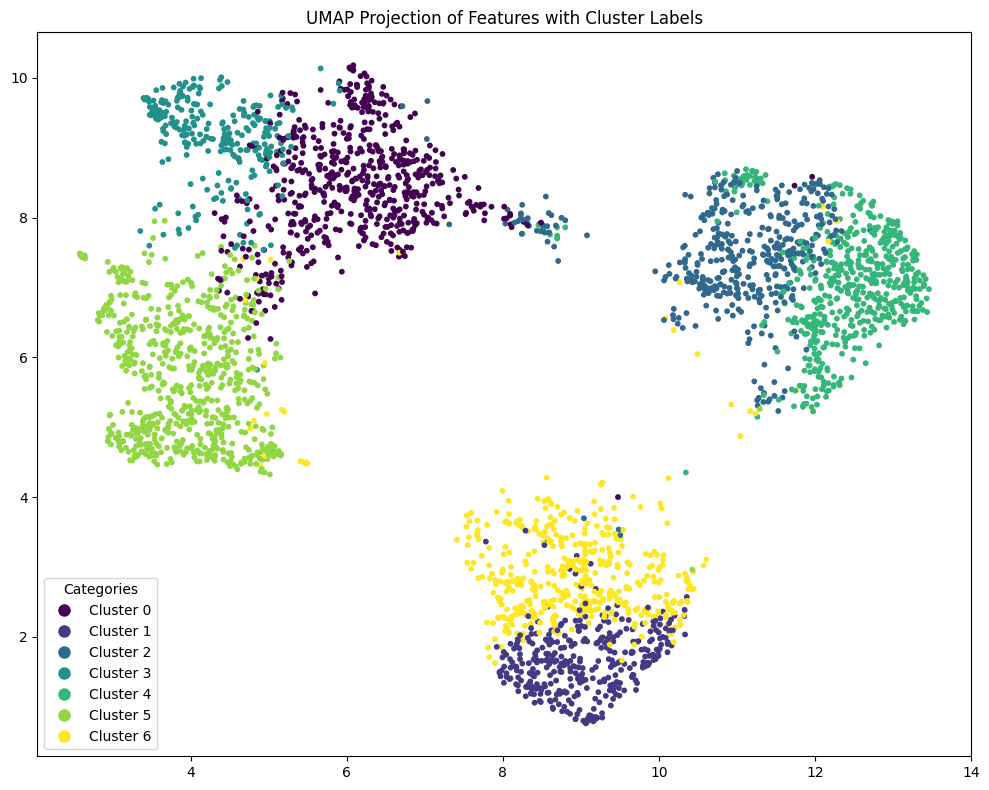

In [75]:
KMeansMetrics(avgpool_features, avg_labels7)
plot_biomarkers(avgpool_features, avg_labels7)

OCT5k - dataset

In [22]:
df = pd.read_csv("C:/Users/voicu/Downloads/OCT5k (1)/OCT5k/Detection/all_bounding_boxes.csv")
class_mapping = {i: cls for i, cls in enumerate(df['class'].unique())}
print(class_mapping)

{0: 'PRlayerdisruption', 1: 'Harddrusen', 2: 'Softdrusen', 3: 'SoftdrusenPED', 4: 'Fluid', 5: 'Hyperfluorescentspots', 6: 'Reticulardrusen', 7: 'Geographicatrophy', 8: 'Choroidalfolds'}


In [23]:
output_dict = {}
image_folder = "C:/Users/voicu/Downloads/OCT5k (1)/OCT5k/Detection/Images"

In [24]:
unique_images = df['image'].unique()

In [25]:
for image in unique_images:
    class_array = [0] * len(class_mapping)
    classes = df[df['image'] == image]['class'].unique()

    for cls in classes:
        if cls in class_mapping.values():
            index = list(class_mapping.values()).index(cls)
            class_array[index] = 1

    output_dict[image] = class_array

In [94]:
oct5k_dataset = OCT5kDataset(image_folder, output_dict, transform=resnet50_transforms)
oct5k_dataloader = DataLoader(oct5k_dataset, batch_size=1, shuffle=True)

In [95]:
predictions = []
category_counts = {i: 0 for i in range(4)}

with torch.no_grad():
    for inputs, file_paths in oct5k_dataloader:
        inputs = inputs.to(cuda)
        outputs = resnet50_features(inputs)
        _, preds = torch.max(outputs, 1)
        category = preds.item()
        predictions.append((file_paths[0], category))
        category_counts[category] += 1

    print("\nCategory counts:")
for category, count in category_counts.items():
    print(f"Category {category}: {count} images")


Category counts:
Category 0: 63 images
Category 1: 29 images
Category 2: 363 images
Category 3: 111 images


In [97]:
oct5k_dataloader = DataLoader(oct5k_dataset, batch_size=32, shuffle=True)

In [98]:
avgpool_layer = resnet50_features.avgpool
hook_oct5k = avgpool_layer.register_forward_hook(get_activation('avgpool'))

In [99]:
oct5k_features, oct5k_labels = extract_conv_features(oct5k_dataloader, resnet50_features, 'avgpool')
hook_oct5k.remove()
print(f"AveragePool Features shape: {oct5k_features.shape}")
print(f"AveragePool Labels shape: {oct5k_labels.shape}")
# KMeans expects 2D array - samples, features
# flatten features
oct5k_features = oct5k_features.reshape(oct5k_features.shape[0], -1)
print(f"AveragePool Features shape: {oct5k_features.shape}")

AveragePool Features shape: (566, 2048, 1, 1)
AveragePool Labels shape: (566, 9)
AveragePool Features shape: (566, 2048)


In [100]:
predicted_categories = kmeans_avg7.predict(oct5k_features)

In [101]:
for i in range(len(oct5k_features)):
    print(f"Feature {i}: Predicted Category: {predicted_categories[i]}, Actual Label: {oct5k_labels[i]}")

Feature 0: Predicted Category: 0, Actual Label: [0 1 1 1 0 0 0 0 1]
Feature 1: Predicted Category: 0, Actual Label: [1 0 1 0 0 0 0 0 0]
Feature 2: Predicted Category: 3, Actual Label: [1 1 1 1 0 1 0 0 0]
Feature 3: Predicted Category: 0, Actual Label: [1 0 1 0 0 0 1 0 0]
Feature 4: Predicted Category: 3, Actual Label: [0 1 1 0 1 1 0 0 0]
Feature 5: Predicted Category: 2, Actual Label: [1 1 0 0 0 0 0 0 0]
Feature 6: Predicted Category: 0, Actual Label: [0 0 1 0 0 0 0 0 0]
Feature 7: Predicted Category: 0, Actual Label: [1 0 1 0 0 0 0 0 0]
Feature 8: Predicted Category: 2, Actual Label: [1 1 0 0 0 0 0 1 0]
Feature 9: Predicted Category: 0, Actual Label: [1 0 0 0 0 0 0 0 0]
Feature 10: Predicted Category: 0, Actual Label: [1 1 0 0 0 0 0 0 0]
Feature 11: Predicted Category: 0, Actual Label: [0 0 1 0 0 0 1 0 0]
Feature 12: Predicted Category: 5, Actual Label: [1 0 0 0 0 0 0 1 0]
Feature 13: Predicted Category: 3, Actual Label: [0 1 1 1 0 0 1 0 1]
Feature 14: Predicted Category: 2, Actual La

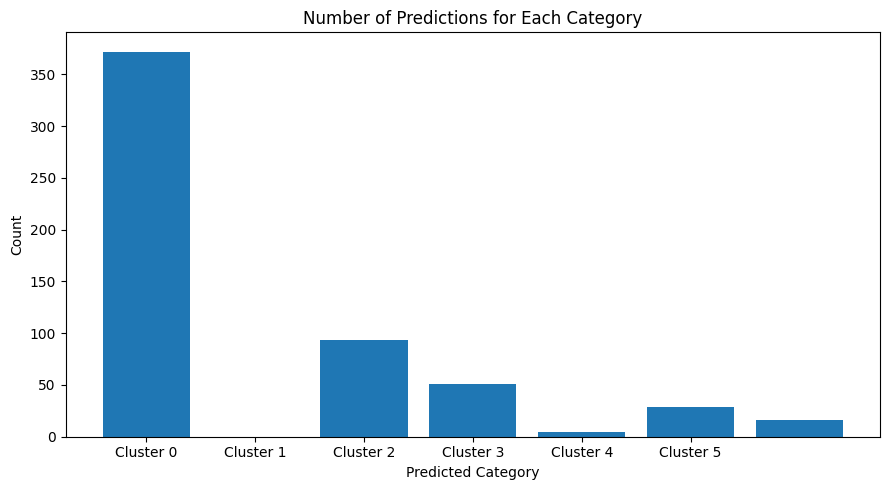

In [102]:
unique, counts = np.unique(predicted_categories, return_counts=True)
prediction_counts = dict(zip(unique, counts))

plt.figure(figsize=(9, 5))
plt.bar(prediction_counts.keys(), prediction_counts.values())
plt.xlabel('Predicted Category')
plt.ylabel('Count')
plt.title('Number of Predictions for Each Category')
plt.xticks(ticks=np.arange(len(prediction_counts)), labels=[f'Cluster {i}' for i in range(len(prediction_counts))])
plt.tight_layout()
plt.show()

In [65]:
cluster_class_counts = {cluster: {cls: 0 for cls in class_mapping.values()} for cluster in range(n_clusters)}

In [66]:
for cluster in range(n_clusters):
    cluster_indices = np.where(predicted_categories == cluster)[0]
    actual_labels_cluster = oct5k_labels[cluster_indices]
    for label_array in actual_labels_cluster:
        for i, present in enumerate(label_array):
            if present:
                cluster_class_counts[cluster][class_mapping[i]] += 1

In [67]:
for cluster, counts in cluster_class_counts.items():
    print(f"\nCluster {cluster} common categories:")
    for cls, count in counts.items():
        if count > 0:
            print(f"{cls}: {count}")


Cluster 0 common categories:
PRlayerdisruption: 140
Harddrusen: 190
Softdrusen: 253
SoftdrusenPED: 68
Fluid: 8
Hyperfluorescentspots: 14
Reticulardrusen: 64
Geographicatrophy: 43
Choroidalfolds: 30

Cluster 1 common categories:
Harddrusen: 1
Fluid: 1
Hyperfluorescentspots: 3

Cluster 2 common categories:
PRlayerdisruption: 46
Harddrusen: 53
Softdrusen: 35
SoftdrusenPED: 8
Fluid: 1
Hyperfluorescentspots: 4
Reticulardrusen: 20
Geographicatrophy: 3
Choroidalfolds: 26

Cluster 3 common categories:
PRlayerdisruption: 12
Harddrusen: 35
Softdrusen: 46
SoftdrusenPED: 13
Fluid: 4
Hyperfluorescentspots: 4
Reticulardrusen: 2
Geographicatrophy: 2
Choroidalfolds: 7

Cluster 4 common categories:
Harddrusen: 2
Softdrusen: 5
Reticulardrusen: 1
Choroidalfolds: 1

Cluster 5 common categories:
PRlayerdisruption: 11
Harddrusen: 22
Softdrusen: 20
SoftdrusenPED: 8
Hyperfluorescentspots: 8
Reticulardrusen: 8
Geographicatrophy: 24


Cluster 0 Class Distribution:
PRlayerdisruption: 145
Harddrusen: 196
Softdrusen: 252
SoftdrusenPED: 67
Fluid: 8
Hyperfluorescentspots: 14
Reticulardrusen: 64
Geographicatrophy: 44
Choroidalfolds: 34

Cluster 3 Class Distribution:
PRlayerdisruption: 12
Harddrusen: 36
Softdrusen: 47
SoftdrusenPED: 14
Fluid: 4
Hyperfluorescentspots: 4
Reticulardrusen: 2
Geographicatrophy: 2
Choroidalfolds: 7


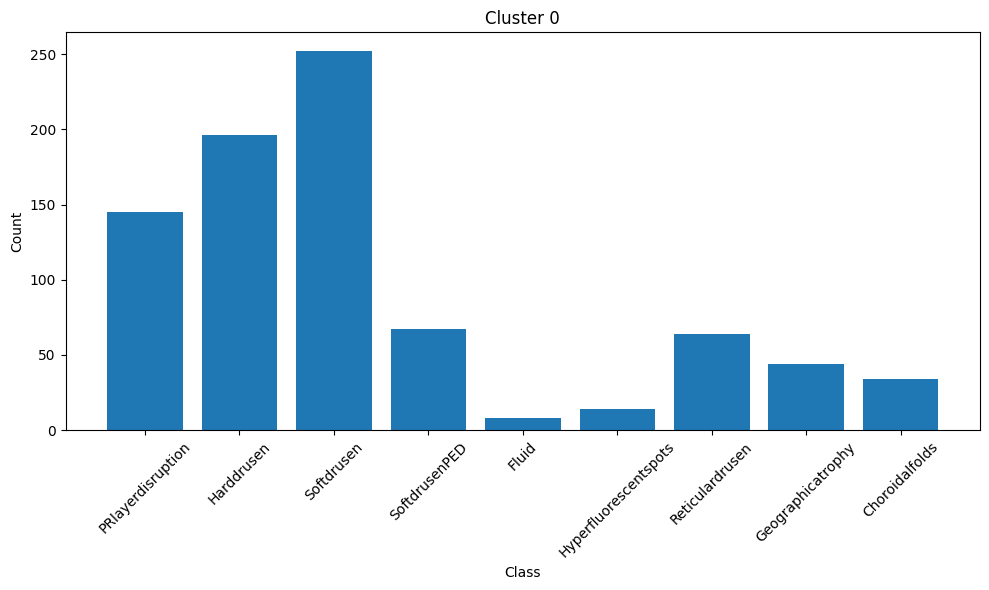

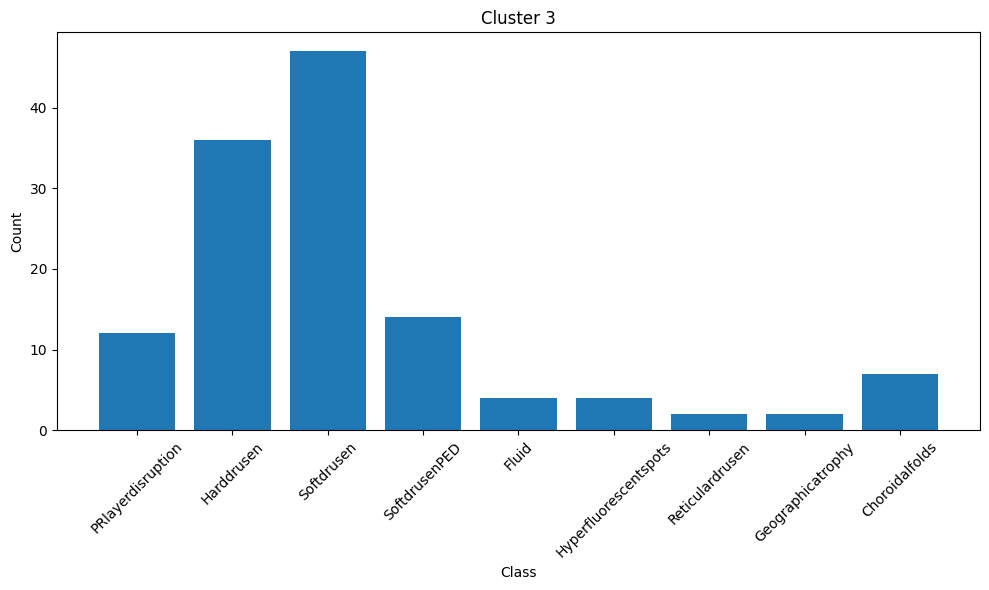

In [103]:
cluster_0_indices = np.where(predicted_categories == 0)[0]
cluster_3_indices = np.where(predicted_categories == 3)[0]

actual_labels_cluster_0 = oct5k_labels[cluster_0_indices]
actual_labels_cluster_3 = oct5k_labels[cluster_3_indices]

cluster_0_class_counts = {cls: 0 for cls in class_mapping.values()}
for label_array in actual_labels_cluster_0:
    for i, present in enumerate(label_array):
        if present:
            cluster_0_class_counts[class_mapping[i]] += 1

cluster_3_class_counts = {cls: 0 for cls in class_mapping.values()}
for label_array in actual_labels_cluster_3:
    for i, present in enumerate(label_array):
        if present:
            cluster_3_class_counts[class_mapping[i]] += 1

print("Cluster 0 Class Distribution:")
for cls, count in cluster_0_class_counts.items():
    print(f"{cls}: {count}")

print("\nCluster 3 Class Distribution:")
for cls, count in cluster_3_class_counts.items():
    print(f"{cls}: {count}")


def plot_class_distribution(cluster_class_counts, cluster_number):
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_class_counts.keys(), cluster_class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'Cluster {cluster_number}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_class_distribution(cluster_0_class_counts, 0)
plot_class_distribution(cluster_3_class_counts, 3)

In [112]:
n_clusters = 10
kmeans_avg10 = KMeans(n_clusters=n_clusters, random_state=42).fit(avgpool_features)
avg_labels10 = kmeans_avg10.predict(avgpool_features)

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        49
           1       0.86      0.89      0.87       108
           2       0.87      0.96      0.91       122
           3       0.72      0.85      0.78        67
           4       0.98      0.77      0.86        62
           5       0.84      0.94      0.89        69
           6       0.88      0.78      0.83        87
           7       1.00      0.67      0.80        24
           8       0.96      0.85      0.90        27
           9       0.91      0.78      0.84        65

    accuracy                           0.86       680
   macro avg       0.88      0.84      0.85       680
weighted avg       0.87      0.86      0.86       680

Accuracy: 0.8602941176470589


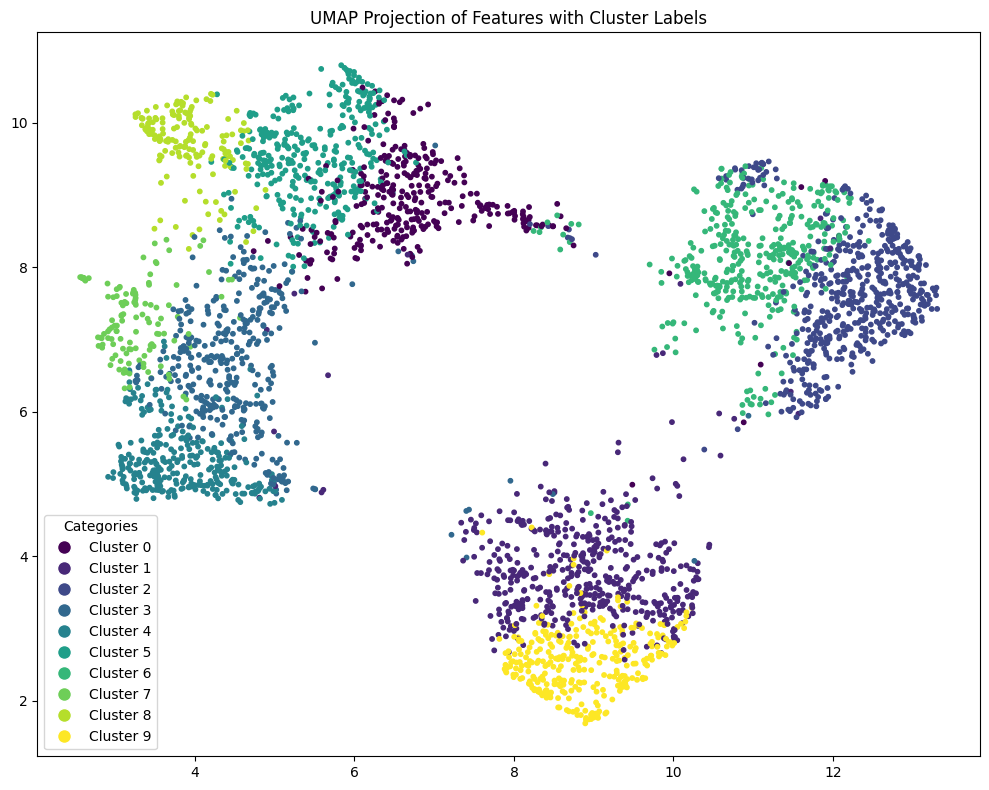

In [113]:
KMeansMetrics(avgpool_features, avg_labels10)
plot_biomarkers(avgpool_features, avg_labels10)

DRUSEN: verde, albastru, roz
Verde -> nu are PRLayerDisruption, Fluid, Hyperfluorescent, Geographycatrophy ft putin hard si soft  (hard 20 ); nu are ReticualrDrusen
Albastru -> putin PRLayerDisruption, Fluid si Hyper aprox 0, putin harddrusen, softdrusen deja are mai mult  (hard 40); putin ReticularDrusen
Roz -> aici e cel mai mult harddrusn (hard 160), aici are mult PRLayerDisruption; aici e ReticularDrusen

in CNV albasatru mai inchis: cele mai multe hperfluorescentspots, destule prlayerdisruption

In [118]:
predicted_categories3 = kmeans_avg10.predict(oct5k_features)

Feature 0: Predicted Category: 3, Actual Label: [0 1 1 1 0 0 0 0 1]
Feature 1: Predicted Category: 0, Actual Label: [1 0 1 0 0 0 0 0 0]
Feature 2: Predicted Category: 5, Actual Label: [1 1 1 1 0 1 0 0 0]
Feature 3: Predicted Category: 3, Actual Label: [1 0 1 0 0 0 1 0 0]
Feature 4: Predicted Category: 5, Actual Label: [0 1 1 0 1 1 0 0 0]
Feature 5: Predicted Category: 0, Actual Label: [1 1 0 0 0 0 0 0 0]
Feature 6: Predicted Category: 5, Actual Label: [0 0 1 0 0 0 0 0 0]
Feature 7: Predicted Category: 0, Actual Label: [1 0 1 0 0 0 0 0 0]
Feature 8: Predicted Category: 0, Actual Label: [1 1 0 0 0 0 0 1 0]
Feature 9: Predicted Category: 0, Actual Label: [1 0 0 0 0 0 0 0 0]
Feature 10: Predicted Category: 0, Actual Label: [1 1 0 0 0 0 0 0 0]
Feature 11: Predicted Category: 3, Actual Label: [0 0 1 0 0 0 1 0 0]
Feature 12: Predicted Category: 3, Actual Label: [1 0 0 0 0 0 0 1 0]
Feature 13: Predicted Category: 3, Actual Label: [0 1 1 1 0 0 1 0 1]
Feature 14: Predicted Category: 6, Actual La

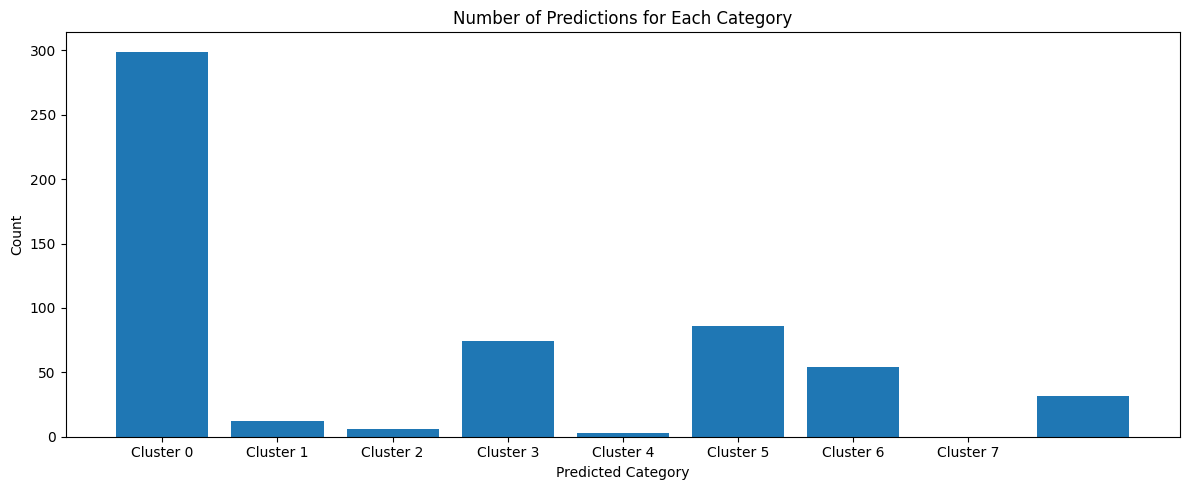

In [120]:
for i in range(len(oct5k_features)):
    print(f"Feature {i}: Predicted Category: {predicted_categories3[i]}, Actual Label: {oct5k_labels[i]}")
unique3, counts3 = np.unique(predicted_categories3, return_counts=True)
prediction_counts3 = dict(zip(unique3, counts3))

plt.figure(figsize=(12, 5))
plt.bar(prediction_counts3.keys(), prediction_counts3.values())
plt.xlabel('Predicted Category')
plt.ylabel('Count')
plt.title('Number of Predictions for Each Category')
plt.xticks(ticks=np.arange(len(prediction_counts3)), labels=[f'Cluster {i}' for i in range(len(prediction_counts3))])
plt.tight_layout()
plt.show()

Cluster 0 Class Distribution:
PRlayerdisruption: 118
Harddrusen: 160
Softdrusen: 170
SoftdrusenPED: 45
Fluid: 7
Hyperfluorescentspots: 10
Reticulardrusen: 53
Geographicatrophy: 29
Choroidalfolds: 29


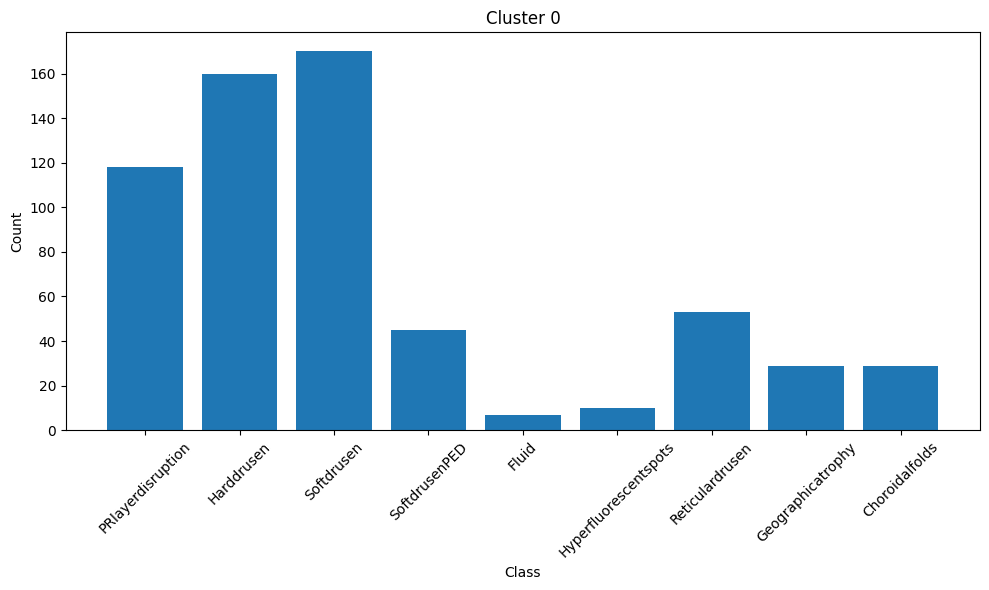

Cluster 5 Class Distribution:
PRlayerdisruption: 27
Harddrusen: 41
Softdrusen: 81
SoftdrusenPED: 14
Fluid: 5
Hyperfluorescentspots: 5
Reticulardrusen: 10
Geographicatrophy: 6
Choroidalfolds: 6


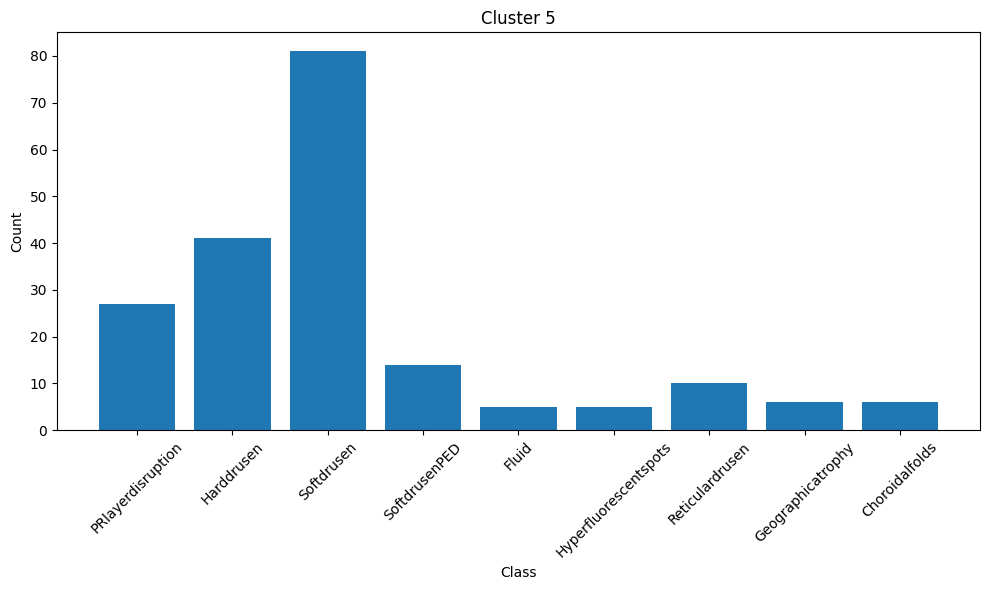

Cluster 8 Class Distribution:
PRlayerdisruption: 3
Harddrusen: 23
Softdrusen: 29
SoftdrusenPED: 10
Fluid: 0
Hyperfluorescentspots: 0
Reticulardrusen: 1
Geographicatrophy: 1
Choroidalfolds: 4


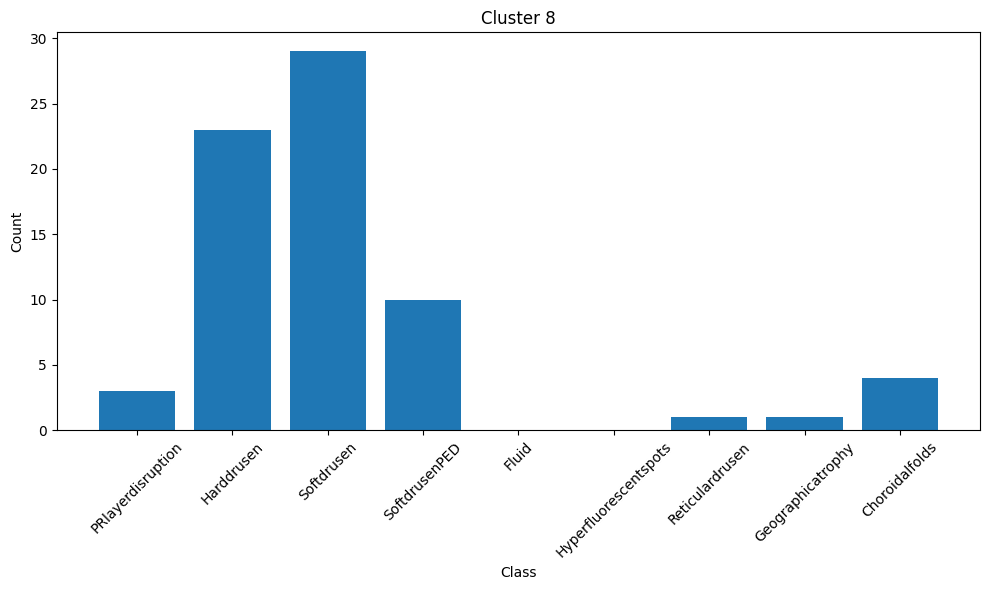

In [121]:
def get_class_counts(cluster_indices, labels, class_mapping):
    class_counts = {cls: 0 for cls in class_mapping.values()}
    for label_array in labels[cluster_indices]:
        for i, present in enumerate(label_array):
            if present:
                class_counts[class_mapping[i]] += 1
    return class_counts


def plot_class_distribution(cluster_class_counts, cluster_number):
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_class_counts.keys(), cluster_class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'Cluster {cluster_number}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


clusters3 = [0, 5, 8]
for cluster_number3 in clusters3:
    cluster_indices3 = np.where(predicted_categories3 == cluster_number3)[0]
    actual_labels_cluster3 = oct5k_labels[cluster_indices3]
    class_counts3 = get_class_counts(cluster_indices3, oct5k_labels, class_mapping)

    print(f"Cluster {cluster_number3} Class Distribution:")
    for cls, count in class_counts3.items():
        print(f"{cls}: {count}")

    plot_class_distribution(class_counts3, cluster_number3)